# Notebook-4: Baselines + Patient-level k-fold CV + Threshold-tuning Claims

Goals (conference-paper ready):
1) Baselines: Plain U-Net, ResUNet (ResNet34 encoder), Attention U-Net (gated skips).
2) Generalization: Patient-level k-fold CV (no leakage across folds).
3) Positioning: Show how conclusions change when using:
   - slice metrics vs patient metrics
   - fixed threshold (0.5) vs validation-tuned threshold

All outputs saved to: `/kaggle/working/paper_outputs_nb4/`.


In [1]:
import os, re, glob, random, math, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet34, ResNet34_Weights
import torchvision.transforms.functional as TF

# -------------------------------
# Paper-style plots
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "axes.linewidth": 1.2,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "legend.fontsize": 11,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",
    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.85,
})
def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(which="both", direction="in", top=True, right=True)

# -------------------------------
# Reproducibility
# -------------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [2]:
CFG = {
    "img_size": 256,
    "batch_size": 16,
    "num_workers": 2,

    "epochs": 8,
    "lr": 3e-4,
    "weight_decay": 1e-4,

    "k_folds": 5,
    "val_frac_in_train": 0.10,  # inside each fold's training pool
    "thresholds": np.linspace(0.1, 0.9, 17),

    "fast_dev_run": False,
    "fast_train_slices": 500,
    "fast_val_slices": 200,

    "amp": True,
}

OUT_DIR = Path("/kaggle/working/paper_outputs_nb4")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR


PosixPath('/kaggle/working/paper_outputs_nb4')

In [3]:
KAGGLE_INPUT = Path("/kaggle/input")
candidates = list(KAGGLE_INPUT.glob("**/kaggle_3m"))
print("Found candidates:", [str(p) for p in candidates[:10]])

if len(candidates) == 0:
    raise FileNotFoundError("Could not find 'kaggle_3m' under /kaggle/input. Attach the dataset.")
DATA_ROOT = candidates[0]
DATA_ROOT


Found candidates: ['/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m', '/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m']


PosixPath('/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m')

In [4]:
def to_key(path):
    base = Path(path).name
    if base.endswith("_mask.tif"):
        base = base.replace("_mask.tif", "")
    else:
        base = base.replace(".tif", "")
    return base

def patient_id_from_path(path):
    return Path(path).parent.name

def slice_index_from_key(k):
    m = re.search(r"_(\d+)$", k)
    return int(m.group(1)) if m else np.nan

all_tifs = sorted(glob.glob(str(DATA_ROOT / "*" / "*.tif")))
mask_tifs = sorted([p for p in all_tifs if p.endswith("_mask.tif")])
img_tifs  = sorted([p for p in all_tifs if not p.endswith("_mask.tif")])

img_map = {to_key(p): p for p in img_tifs}
msk_map = {to_key(p): p for p in mask_tifs}
keys = sorted(set(img_map.keys()) & set(msk_map.keys()))

df = pd.DataFrame({
    "key": keys,
    "image_path": [img_map[k] for k in keys],
    "mask_path":  [msk_map[k] for k in keys],
})
df["patient_id"] = df["image_path"].apply(patient_id_from_path)
df["slice_idx"] = df["key"].apply(slice_index_from_key)
df = df.sort_values(["patient_id", "slice_idx", "key"]).reset_index(drop=True)

print("Slices:", len(df), "| Patients:", df["patient_id"].nunique())
df.head()


Slices: 3929 | Patients: 110


,key,image_path,mask_path,patient_id,slice_idx
0,TCGA_CS_4941_19960909_1,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,1
1,TCGA_CS_4941_19960909_2,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,2
2,TCGA_CS_4941_19960909_3,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,3
3,TCGA_CS_4941_19960909_4,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,4
4,TCGA_CS_4941_19960909_5,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,5


In [5]:
def load_tif(path):
    return np.array(Image.open(path))

def to_mask01(msk):
    if msk.ndim == 3:
        m = msk[..., 0]
    else:
        m = msk
    return (m > 0).astype(np.uint8)

class TorchvisionAugment:
    def __init__(self, train=True):
        self.train = train

    def __call__(self, img, msk):
        img_t = TF.to_tensor(img)  # (3,H,W) float [0,1]
        msk_t = torch.from_numpy(msk).unsqueeze(0).float()

        if self.train:
            if torch.rand(1).item() < 0.5:
                img_t = TF.hflip(img_t); msk_t = TF.hflip(msk_t)
            if torch.rand(1).item() < 0.2:
                img_t = TF.vflip(img_t); msk_t = TF.vflip(msk_t)

            angle = float((torch.rand(1).item() - 0.5) * 24.0)  # [-12,12]
            img_t = TF.rotate(img_t, angle, interpolation=TF.InterpolationMode.BILINEAR)
            msk_t = TF.rotate(msk_t, angle, interpolation=TF.InterpolationMode.NEAREST)

            if torch.rand(1).item() < 0.25:
                b = 0.9 + 0.2 * torch.rand(1).item()
                c = 0.9 + 0.2 * torch.rand(1).item()
                img_t = TF.adjust_brightness(img_t, b)
                img_t = TF.adjust_contrast(img_t, c)

            if torch.rand(1).item() < 0.15:
                try:
                    img_t = TF.gaussian_blur(img_t, kernel_size=[3,3], sigma=[0.1, 1.2])
                except Exception:
                    pass

        return img_t.float(), msk_t.float()

train_tfms = TorchvisionAugment(train=True)
eval_tfms  = TorchvisionAugment(train=False)

class LGGSegDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = load_tif(r.image_path)
        msk = to_mask01(load_tif(r.mask_path))

        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)

        if self.tfms is None:
            img_t = TF.to_tensor(img).float()
            msk_t = torch.from_numpy(msk).unsqueeze(0).float()
            return img_t, msk_t

        return self.tfms(img, msk)


In [6]:
# ---- Quick loader just for sanity testing "Ours" forward ----
patients = df["patient_id"].drop_duplicates().tolist()
rng = np.random.default_rng(SEED)
rng.shuffle(patients)

# simple patient split (only to create val_loader for the test)
n = len(patients)
val_pat = set(patients[int(0.8*n): int(0.9*n)])
val_df_quick = df[df["patient_id"].isin(val_pat)].copy().reset_index(drop=True)

val_ds_quick = LGGSegDataset(val_df_quick, tfms=eval_tfms)
val_loader_quick = DataLoader(
    val_ds_quick, batch_size=CFG["batch_size"], shuffle=False,
    num_workers=CFG["num_workers"], pin_memory=True
)

print("val slices:", len(val_ds_quick), "| val patients:", val_df_quick["patient_id"].nunique())


val slices: 426 | val patients: 11


In [7]:
bce = nn.BCEWithLogitsLoss()

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs * targets).sum(dim=(2,3))
        den = (probs + targets).sum(dim=(2,3)) + self.eps
        return 1.0 - (num / den).mean()

def total_loss(logits, targets):
    return 0.6 * bce(logits, targets) + 0.4 * DiceLoss()(logits, targets)

@torch.no_grad()
def dice_iou_from_bin(pred_bin, targ, eps=1e-7):
    inter = (pred_bin * targ).sum(dim=(2,3))
    dice = (2*inter) / (pred_bin.sum(dim=(2,3)) + targ.sum(dim=(2,3)) + eps)
    union = (pred_bin + targ - pred_bin*targ).sum(dim=(2,3)) + eps
    iou = inter / union
    return dice.squeeze(1), iou.squeeze(1)

@torch.no_grad()
def eval_slice_and_patient(model, loader, df_ref, threshold=0.5):
    model.eval()
    ptr = 0
    rows = []
    losses = []

    for xb, yb in loader:
        bs = xb.size(0)
        batch_df = df_ref.iloc[ptr:ptr+bs]
        ptr += bs

        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        losses.append(float(total_loss(logits, yb).item()))

        probs = torch.sigmoid(logits)
        pred_bin = (probs > threshold).float()

        dice_b, iou_b = dice_iou_from_bin(pred_bin, yb)
        for i in range(bs):
            rows.append({
                "patient_id": batch_df.iloc[i]["patient_id"],
                "key": batch_df.iloc[i]["key"],
                "slice_dice": float(dice_b[i].item()),
                "slice_iou": float(iou_b[i].item()),
                "gt_area": float(yb[i,0].sum().item()),
                "pred_area": float(pred_bin[i,0].sum().item()),
            })

    slice_df = pd.DataFrame(rows)
    # patient metric = mean over slices, then mean over patients
    pat_df = slice_df.groupby("patient_id", as_index=False).agg(
        patient_dice=("slice_dice", "mean"),
        patient_iou=("slice_iou", "mean"),
        mean_gt_area=("gt_area", "mean"),
    )

    out = {
        "loss": float(np.mean(losses)) if len(losses) else np.nan,
        "slice_dice_mean": float(slice_df["slice_dice"].mean()),
        "slice_iou_mean": float(slice_df["slice_iou"].mean()),
        "patient_dice_mean": float(pat_df["patient_dice"].mean()),
        "patient_iou_mean": float(pat_df["patient_iou"].mean()),
        "slice_df": slice_df,
        "patient_df": pat_df,
    }
    return out

@torch.no_grad()
def tune_threshold_on_val(model, val_loader, val_ref, thresholds):
    best = {"threshold": 0.5, "patient_dice_mean": -1}
    for t in thresholds:
        out = eval_slice_and_patient(model, val_loader, val_ref, threshold=float(t))
        if out["patient_dice_mean"] > best["patient_dice_mean"]:
            best = {"threshold": float(t), "patient_dice_mean": out["patient_dice_mean"]}
    return best


In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(out_ch + skip_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.inc = DoubleConv(in_ch, base)
        self.d1 = Down(base, base*2)
        self.d2 = Down(base*2, base*4)
        self.d3 = Down(base*4, base*8)
        self.d4 = Down(base*8, base*16)

        self.u1 = Up(base*16, base*8, base*8)
        self.u2 = Up(base*8, base*4, base*4)
        self.u3 = Up(base*4, base*2, base*2)
        self.u4 = Up(base*2, base, base)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.d1(x1)
        x3 = self.d2(x2)
        x4 = self.d3(x3)
        x5 = self.d4(x4)

        x = self.u1(x5, x4)
        x = self.u2(x,  x3)
        x = self.u3(x,  x2)
        x = self.u4(x,  x1)
        return self.outc(x)


In [9]:
class AttentionGate(nn.Module):
    def __init__(self, skip_ch, gate_ch, inter_ch):
        super().__init__()
        self.theta = nn.Sequential(nn.Conv2d(skip_ch, inter_ch, 1, bias=False),
                                   nn.BatchNorm2d(inter_ch))
        self.phi   = nn.Sequential(nn.Conv2d(gate_ch, inter_ch, 1, bias=False),
                                   nn.BatchNorm2d(inter_ch))
        self.psi   = nn.Sequential(nn.Conv2d(inter_ch, 1, 1, bias=True),
                                   nn.Sigmoid())

        self.relu = nn.ReLU(inplace=True)

    def forward(self, skip, gate):
        if gate.shape[-2:] != skip.shape[-2:]:
            gate = F.interpolate(gate, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = self.relu(self.theta(skip) + self.phi(gate))
        attn = self.psi(x)
        return skip * attn

class AttnUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.inc = DoubleConv(in_ch, base)
        self.d1 = Down(base, base*2)
        self.d2 = Down(base*2, base*4)
        self.d3 = Down(base*4, base*8)
        self.d4 = Down(base*8, base*16)

        self.up1 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.ag1 = AttentionGate(skip_ch=base*8, gate_ch=base*8, inter_ch=base*4)
        self.cv1 = DoubleConv(base*16, base*8)

        self.up2 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.ag2 = AttentionGate(skip_ch=base*4, gate_ch=base*4, inter_ch=base*2)
        self.cv2 = DoubleConv(base*8, base*4)

        self.up3 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.ag3 = AttentionGate(skip_ch=base*2, gate_ch=base*2, inter_ch=base)
        self.cv3 = DoubleConv(base*4, base*2)

        self.up4 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.ag4 = AttentionGate(skip_ch=base, gate_ch=base, inter_ch=base//2)
        self.cv4 = DoubleConv(base*2, base)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.d1(x1)
        x3 = self.d2(x2)
        x4 = self.d3(x3)
        x5 = self.d4(x4)

        g = self.up1(x5)
        if g.shape[-2:] != x4.shape[-2:]:
            g = F.interpolate(g, size=x4.shape[-2:], mode="bilinear", align_corners=False)
        x4a = self.ag1(x4, g)
        x = self.cv1(torch.cat([x4a, g], dim=1))

        g = self.up2(x)
        if g.shape[-2:] != x3.shape[-2:]:
            g = F.interpolate(g, size=x3.shape[-2:], mode="bilinear", align_corners=False)
        x3a = self.ag2(x3, g)
        x = self.cv2(torch.cat([x3a, g], dim=1))

        g = self.up3(x)
        if g.shape[-2:] != x2.shape[-2:]:
            g = F.interpolate(g, size=x2.shape[-2:], mode="bilinear", align_corners=False)
        x2a = self.ag3(x2, g)
        x = self.cv3(torch.cat([x2a, g], dim=1))

        g = self.up4(x)
        if g.shape[-2:] != x1.shape[-2:]:
            g = F.interpolate(g, size=x1.shape[-2:], mode="bilinear", align_corners=False)
        x1a = self.ag4(x1, g)
        x = self.cv4(torch.cat([x1a, g], dim=1))

        return self.outc(x)


In [10]:
class ResUNet34(nn.Module):
    def __init__(self, pretrained=True, out_ch=1):
        super().__init__()
        weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        m = resnet34(weights=weights)

        self.enc0 = nn.Sequential(m.conv1, m.bn1, m.relu)  # /2
        self.pool = m.maxpool                              # /4
        self.enc1 = m.layer1                               # /4
        self.enc2 = m.layer2                               # /8
        self.enc3 = m.layer3                               # /16
        self.enc4 = m.layer4                               # /32

        # Decoder (channels from resnet34: 64,64,128,256,512)
        self.up1 = Up(in_ch=512, skip_ch=256, out_ch=256)
        self.up2 = Up(in_ch=256, skip_ch=128, out_ch=128)
        self.up3 = Up(in_ch=128, skip_ch=64,  out_ch=64)
        self.up4 = Up(in_ch=64,  skip_ch=64,  out_ch=32)   # skip from enc0

        self.outc = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        x0 = self.enc0(x)     # (64, H/2, W/2)
        x1 = self.pool(x0)    # (64, H/4, W/4)
        x1 = self.enc1(x1)    # (64, H/4, W/4)
        x2 = self.enc2(x1)    # (128, H/8, W/8)
        x3 = self.enc3(x2)    # (256, H/16, W/16)
        x4 = self.enc4(x3)    # (512, H/32, W/32)

        x = self.up1(x4, x3)
        x = self.up2(x,  x2)
        x = self.up3(x,  x1)
        x = self.up4(x,  x0)

        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)  # back to H,W
        return self.outc(x)


In [11]:
def make_patient_folds(df, k=5, seed=7):
    patients = df["patient_id"].drop_duplicates().tolist()
    rng = np.random.default_rng(seed)
    rng.shuffle(patients)
    folds = [patients[i::k] for i in range(k)]
    return folds

folds = make_patient_folds(df, k=CFG["k_folds"], seed=SEED)
[len(f) for f in folds], sum(len(f) for f in folds)


([22, 22, 22, 22, 22], 110)

In [12]:
def split_for_fold(df, test_patients, val_frac=0.1, seed=7):
    test_patients = set(test_patients)
    rest = df[~df["patient_id"].isin(test_patients)].copy()
    test = df[df["patient_id"].isin(test_patients)].copy()

    rest_pat = rest["patient_id"].drop_duplicates().tolist()
    rng = np.random.default_rng(seed)
    rng.shuffle(rest_pat)

    n_val = max(1, int(round(val_frac * len(rest_pat))))
    val_pat = set(rest_pat[:n_val])
    train_pat = set(rest_pat[n_val:])

    train = rest[rest["patient_id"].isin(train_pat)].copy()
    val   = rest[rest["patient_id"].isin(val_pat)].copy()

    train = train.sort_values(["patient_id","slice_idx","key"]).reset_index(drop=True)
    val   = val.sort_values(["patient_id","slice_idx","key"]).reset_index(drop=True)
    test  = test.sort_values(["patient_id","slice_idx","key"]).reset_index(drop=True)
    return train, val, test


In [13]:
def make_loaders(train_df, val_df, test_df):
    if CFG["fast_dev_run"]:
        train_df = train_df.iloc[:CFG["fast_train_slices"]].copy().reset_index(drop=True)
        val_df   = val_df.iloc[:CFG["fast_val_slices"]].copy().reset_index(drop=True)

    train_ds = LGGSegDataset(train_df, tfms=train_tfms)
    val_ds   = LGGSegDataset(val_df, tfms=eval_tfms)
    test_ds  = LGGSegDataset(test_df, tfms=eval_tfms)

    train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,
                              num_workers=CFG["num_workers"], pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                              num_workers=CFG["num_workers"], pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                              num_workers=CFG["num_workers"], pin_memory=True)
    return (train_loader, val_loader, test_loader)

def train_model(model, train_loader, val_loader, val_ref, epochs, lr, wd):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.amp.GradScaler("cuda", enabled=(device=="cuda" and CFG["amp"]))

    best = {"epoch": -1, "val_patient_dice": -1, "state": None}
    history = []

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=(device=="cuda" and CFG["amp"])):
                logits = model(xb)
                loss = total_loss(logits, yb)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            losses.append(float(loss.item()))

        val_out = eval_slice_and_patient(model, val_loader, val_ref, threshold=0.5)
        row = {
            "epoch": ep,
            "train_loss": float(np.mean(losses)),
            "val_loss": val_out["loss"],
            "val_patient_dice@0.5": val_out["patient_dice_mean"],
            "val_slice_dice@0.5": val_out["slice_dice_mean"],
        }
        history.append(row)

        if val_out["patient_dice_mean"] > best["val_patient_dice"]:
            best = {"epoch": ep, "val_patient_dice": val_out["patient_dice_mean"],
                    "state": {k:v.detach().cpu() for k,v in model.state_dict().items()}}

    hist_df = pd.DataFrame(history)
    model.load_state_dict(best["state"])
    return model, hist_df, best


# Classes from Notebook 3

In [14]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv1 = ConvBNReLU(out_ch + skip_ch, out_ch)
        self.conv2 = ConvBNReLU(out_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class BottleneckMHSA(nn.Module):
    def __init__(self, channels, heads=8, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(channels)
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=heads,
                                          dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(channels)
        self.ffn = nn.Sequential(
            nn.Linear(channels, channels*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(channels*4, channels),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        tokens = x.permute(0,2,3,1).reshape(b, h*w, c)
        t = self.norm1(tokens)
        attn_out, _ = self.attn(t, t, t, need_weights=False)
        tokens = tokens + attn_out
        t2 = self.norm2(tokens)
        tokens = tokens + self.ffn(t2)
        return tokens.reshape(b, h, w, c).permute(0,3,1,2)

class ResNet34UNetAttn(nn.Module):
    def __init__(self, pretrained=True, use_attention=True, attn_heads=8):
        super().__init__()
        weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        self.encoder = resnet34(weights=weights)

        self.conv1 = self.encoder.conv1
        self.bn1   = self.encoder.bn1
        self.relu  = self.encoder.relu
        self.maxp  = self.encoder.maxpool

        self.layer1 = self.encoder.layer1
        self.layer2 = self.encoder.layer2
        self.layer3 = self.encoder.layer3
        self.layer4 = self.encoder.layer4

        self.attn = BottleneckMHSA(512, heads=attn_heads) if use_attention else nn.Identity()

        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 64)
        self.up0 = UpBlock(64, 64, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.relu(self.bn1(self.conv1(x)))      # (B,64,128,128)
        x1 = self.layer1(self.maxp(x0))              # (B,64,64,64)
        x2 = self.layer2(x1)                         # (B,128,32,32)
        x3 = self.layer3(x2)                         # (B,256,16,16)
        x4 = self.layer4(x3)                         # (B,512,8,8)

        x4 = self.attn(x4)

        d3 = self.up3(x4, x3)
        d2 = self.up2(d3, x2)
        d1 = self.up1(d2, x1)
        d0 = self.up0(d1, x0)

        d0 = F.interpolate(d0, scale_factor=2, mode="bilinear", align_corners=False)
        return self.out(d0)

# Comparsion

In [15]:
from pathlib import Path
import glob

# Finds the dataset folder that contains the checkpoints
CKPT_MATCH = list(Path("/kaggle/input").glob("**/best_attn1_freeze0.pt"))
if not CKPT_MATCH:
    raise FileNotFoundError("best_attn1_freeze0.pt not found under /kaggle/input")

CKPT_ROOT = CKPT_MATCH[0].parent
print("CKPT_ROOT =", CKPT_ROOT)
print("Files:", sorted([p.name for p in CKPT_ROOT.glob("*.pt")]))


CKPT_ROOT = /kaggle/input/datasets/katakuricharlotte/brainmri-notebook3-outputs
Files: ['best_attn0_freeze0.pt', 'best_attn0_freeze1.pt', 'best_attn1_freeze0.pt', 'best_attn1_freeze1.pt']


In [16]:
import torch

p = CKPT_ROOT / "best_attn1_freeze0.pt"
obj = torch.load(p, map_location="cpu")

print(type(obj))
if isinstance(obj, dict):
    print("dict keys (first 20):", list(obj.keys())[:20])
    # heuristic: state_dict usually has tensor values
    any_tensor = any(hasattr(v, "shape") for v in obj.values())
    print("looks_like_state_dict =", any_tensor)


<class 'dict'>
dict keys (first 20): ['model', 'config', 'CFG']
looks_like_state_dict = False


# From Notebook-3:
- Conv blocks
- Self-attention (if used)
- ResNet encoder wrapper (if used)
- Your final model class

# Example placeholder name (replace with your true class):
- class OursResUNet(nn.Module):



In [17]:
import torch
from pathlib import Path

def set_encoder_trainable(model, trainable: bool):
    # your class stores encoder as model.encoder = resnet34(...)
    for p in model.encoder.parameters():
        p.requires_grad = trainable

def build_ours_from_ckpt(attn: int, freeze: int, ckpt_root: Path = None, attn_heads: int = 8):
    if ckpt_root is None:
        ckpt_root = CKPT_ROOT

    ckpt_path = ckpt_root / f"best_attn{attn}_freeze{freeze}.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")

    # Construct architecture (must match Notebook-3)
    model = ResNet34UNetAttn(pretrained=True, use_attention=bool(attn), attn_heads=attn_heads)

    # Apply freeze flag (freeze=1 => encoder not trainable)
    set_encoder_trainable(model, trainable=(freeze == 0))

    # Extract state_dict
    if isinstance(ckpt, dict) and ("model" in ckpt):
        state_dict = ckpt["model"]
    else:
        state_dict = ckpt  # if it was saved as raw state_dict

    model.load_state_dict(state_dict, strict=True)
    return model


In [18]:
def build_model(name):
    if name == "UNet":
        return UNet(in_ch=3, out_ch=1, base=32)
    if name == "ResUNet34":
        return ResUNet34(pretrained=True, out_ch=1)
    if name == "AttnUNet":
        return AttnUNet(in_ch=3, out_ch=1, base=32)

    # ---- Ours (Notebook-3 checkpoints) ----
    if name == "Ours_AttnFinetune":
        return build_ours_from_ckpt(attn=1, freeze=0, ckpt_root=CKPT_ROOT)

    if name == "Ours_NoAttnFinetune":
        return build_ours_from_ckpt(attn=0, freeze=0, ckpt_root=CKPT_ROOT)
    if name == "Ours_NoAttnFrozen":
        return build_ours_from_ckpt(attn=0, freeze=1, ckpt_root=CKPT_ROOT)
    if name == "Ours_AttnFrozen":
        return build_ours_from_ckpt(attn=1, freeze=1, ckpt_root=CKPT_ROOT)

    raise ValueError("Unknown model: " + name)


MODEL_NAMES = ["UNet", "ResUNet34", "AttnUNet", "Ours_AttnFinetune"]
MODEL_NAMES

['UNet', 'ResUNet34', 'AttnUNet', 'Ours_AttnFinetune']

# quick sanity test

In [19]:
m = build_model("Ours_AttnFinetune").to(device)
m.eval()

xb, yb = next(iter(val_loader_quick))
with torch.no_grad():
    out = m(xb.to(device))

print("OK. out:", tuple(out.shape))


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:05<00:00, 15.8MB/s]


OK. out: (16, 1, 256, 256)


In [20]:
all_rows = []
all_hist = []

for fold_idx in range(CFG["k_folds"]):
    test_pat = folds[fold_idx]
    train_df, val_df, test_df = split_for_fold(
        df, test_pat, val_frac=CFG["val_frac_in_train"], seed=SEED + fold_idx
    )

    train_loader, val_loader, test_loader = make_loaders(train_df, val_df, test_df)

    train_ref = train_df.reset_index(drop=True)
    val_ref   = val_df.reset_index(drop=True)
    test_ref  = test_df.reset_index(drop=True)

    print(
        f"\n=== Fold {fold_idx+1}/{CFG['k_folds']} | "
        f"train_pat={train_df.patient_id.nunique()} "
        f"val_pat={val_df.patient_id.nunique()} "
        f"test_pat={test_df.patient_id.nunique()}"
    )

    for mname in MODEL_NAMES:
        torch.cuda.empty_cache()

        is_ours = mname.startswith("Ours_")

        if is_ours:
            model = build_model(mname).to(device)
            model.eval()

            tuned = tune_threshold_on_val(model, val_loader, val_ref, CFG["thresholds"])
            best_t = tuned["threshold"]

            test_fixed = eval_slice_and_patient(model, test_loader, test_ref, threshold=0.5)
            test_tuned = eval_slice_and_patient(model, test_loader, test_ref, threshold=best_t)

            all_rows.append({
                "fold": fold_idx,
                "model": mname,
                "best_epoch_by_val_patient_dice@0.5": -1,
                "val_best_patient_dice@0.5": np.nan,
                "val_best_threshold": float(best_t),
                "test_patient_dice@0.5": float(test_fixed["patient_dice_mean"]),
                "test_patient_dice@tuned": float(test_tuned["patient_dice_mean"]),
                "test_slice_dice@0.5": float(test_fixed["slice_dice_mean"]),
                "test_slice_dice@tuned": float(test_tuned["slice_dice_mean"]),
            })
            continue

        model = build_model(mname)

        model, hist_df, best = train_model(
            model,
            train_loader=train_loader,
            val_loader=val_loader,
            val_ref=val_ref,
            epochs=CFG["epochs"],
            lr=CFG["lr"],
            wd=CFG["weight_decay"],
        )

        hist_df["fold"] = fold_idx
        hist_df["model"] = mname
        all_hist.append(hist_df)

        tuned = tune_threshold_on_val(model, val_loader, val_ref, CFG["thresholds"])
        best_t = tuned["threshold"]

        test_fixed = eval_slice_and_patient(model, test_loader, test_ref, threshold=0.5)
        test_tuned = eval_slice_and_patient(model, test_loader, test_ref, threshold=best_t)

        all_rows.append({
            "fold": fold_idx,
            "model": mname,
            "best_epoch_by_val_patient_dice@0.5": int(best["epoch"]),
            "val_best_patient_dice@0.5": float(best["val_patient_dice"]),
            "val_best_threshold": float(best_t),
            "test_patient_dice@0.5": float(test_fixed["patient_dice_mean"]),
            "test_patient_dice@tuned": float(test_tuned["patient_dice_mean"]),
            "test_slice_dice@0.5": float(test_fixed["slice_dice_mean"]),
            "test_slice_dice@tuned": float(test_tuned["slice_dice_mean"]),
        })

cv_df = pd.DataFrame(all_rows)

if len(all_hist) > 0:
    hist_all = pd.concat(all_hist, ignore_index=True)
else:
    hist_all = pd.DataFrame()

cv_csv = OUT_DIR / "cv_results.csv"
hist_csv = OUT_DIR / "cv_history.csv"

cv_df.to_csv(cv_csv, index=False)
hist_all.to_csv(hist_csv, index=False)

print("Saved:", cv_csv)
print("Saved:", hist_csv)

cv_df.head()



=== Fold 1/5 | train_pat=79 val_pat=9 test_pat=22

=== Fold 2/5 | train_pat=79 val_pat=9 test_pat=22

=== Fold 3/5 | train_pat=79 val_pat=9 test_pat=22

=== Fold 4/5 | train_pat=79 val_pat=9 test_pat=22

=== Fold 5/5 | train_pat=79 val_pat=9 test_pat=22
Saved: /kaggle/working/paper_outputs_nb4/cv_results.csv
Saved: /kaggle/working/paper_outputs_nb4/cv_history.csv


,fold,model,best_epoch_by_val_patient_dice@0.5,val_best_patient_dice@0.5,val_best_threshold,test_patient_dice@0.5,test_patient_dice@tuned,test_slice_dice@0.5,test_slice_dice@tuned
0,0,UNet,8,0.283627,0.75,0.249810,0.246100,0.261463,0.258677
1,0,ResUNet34,8,0.317732,0.80,0.284378,0.276559,0.296842,0.289198
2,0,AttnUNet,6,0.288419,0.75,0.235974,0.238020,0.250459,0.249855
3,0,Ours_AttnFinetune,-1,NaN,0.90,0.306159,0.301695,0.318033,0.313479
4,1,UNet,8,0.330705,0.75,0.229718,0.227366,0.226233,0.224981


In [21]:
def mean_std(x):
    return float(np.mean(x)), float(np.std(x, ddof=1)) if len(x) > 1 else 0.0

agg_rows = []
for mname in MODEL_NAMES:
    sub = cv_df[cv_df["model"] == mname]
    mu_pt_fixed, sd_pt_fixed = mean_std(sub["test_patient_dice@0.5"])
    mu_pt_tune,  sd_pt_tune  = mean_std(sub["test_patient_dice@tuned"])
    mu_sl_fixed, sd_sl_fixed = mean_std(sub["test_slice_dice@0.5"])
    mu_sl_tune,  sd_sl_tune  = mean_std(sub["test_slice_dice@tuned"])
    mu_t, sd_t = mean_std(sub["val_best_threshold"])

    agg_rows.append({
        "model": mname,
        "val_threshold_mean": mu_t, "val_threshold_std": sd_t,
        "test_patient_dice@0.5_mean": mu_pt_fixed, "test_patient_dice@0.5_std": sd_pt_fixed,
        "test_patient_dice@tuned_mean": mu_pt_tune, "test_patient_dice@tuned_std": sd_pt_tune,
        "test_slice_dice@0.5_mean": mu_sl_fixed, "test_slice_dice@0.5_std": sd_sl_fixed,
        "test_slice_dice@tuned_mean": mu_sl_tune, "test_slice_dice@tuned_std": sd_sl_tune,
    })

agg_df = pd.DataFrame(agg_rows).sort_values("test_patient_dice@tuned_mean", ascending=False).reset_index(drop=True)

agg_csv = OUT_DIR / "cv_aggregate_mean_std.csv"
agg_df.to_csv(agg_csv, index=False)

latex_df = agg_df.copy()
for c in latex_df.columns:
    if c != "model":
        latex_df[c] = latex_df[c].map(lambda v: f"{v:.4f}")
latex_tex = OUT_DIR / "cv_aggregate_mean_std.tex"
latex_df.to_latex(latex_tex, index=False)

print("Saved:", agg_csv)
print("Saved:", latex_tex)
agg_df


Saved: /kaggle/working/paper_outputs_nb4/cv_aggregate_mean_std.csv
Saved: /kaggle/working/paper_outputs_nb4/cv_aggregate_mean_std.tex


,model,val_threshold_mean,val_threshold_std,test_patient_dice@0.5_mean,test_patient_dice@0.5_std,test_patient_dice@tuned_mean,test_patient_dice@tuned_std,test_slice_dice@0.5_mean,test_slice_dice@0.5_std,test_slice_dice@tuned_mean,test_slice_dice@tuned_std
0,Ours_AttnFinetune,0.62,0.182346,0.297336,0.015060,0.296529,0.014641,0.291630,0.022977,0.290734,0.021863
1,ResUNet34,0.66,0.167332,0.269852,0.013407,0.267096,0.010891,0.260793,0.028805,0.258032,0.026333
2,AttnUNet,0.46,0.315040,0.236611,0.008626,0.238647,0.009131,0.226291,0.022111,0.228007,0.022063
3,UNet,0.60,0.154110,0.228754,0.018136,0.227517,0.017282,0.217264,0.032429,0.216388,0.031562


In [22]:
def rank_models(series_by_model):
    s = series_by_model.sort_values(ascending=False)
    return {m: int(i+1) for i, m in enumerate(s.index.tolist())}

r_slice_fixed = rank_models(agg_df.set_index("model")["test_slice_dice@0.5_mean"])
r_patient_tuned = rank_models(agg_df.set_index("model")["test_patient_dice@tuned_mean"])

rank_rows = []
for m in MODEL_NAMES:
    rank_rows.append({
        "model": m,
        "rank_by_slice_dice@0.5": r_slice_fixed[m],
        "rank_by_patient_dice@tuned": r_patient_tuned[m],
        "rank_shift": r_slice_fixed[m] - r_patient_tuned[m],
    })

rank_df = pd.DataFrame(rank_rows).sort_values("rank_by_patient_dice@tuned").reset_index(drop=True)
rank_csv = OUT_DIR / "ranking_shift.csv"
rank_df.to_csv(rank_csv, index=False)
print("Saved:", rank_csv)
rank_df


Saved: /kaggle/working/paper_outputs_nb4/ranking_shift.csv


,model,rank_by_slice_dice@0.5,rank_by_patient_dice@tuned,rank_shift
0,Ours_AttnFinetune,1,1,0
1,ResUNet34,2,2,0
2,AttnUNet,3,3,0
3,UNet,4,4,0


/tmp/ipykernel_25/449774826.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=MODEL_NAMES, showmeans=True)


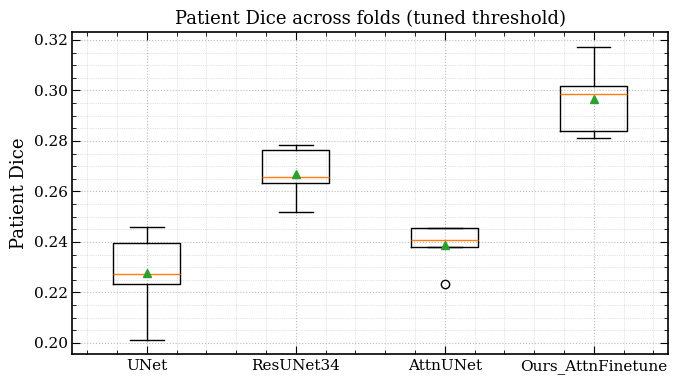

Saved: /kaggle/working/paper_outputs_nb4/boxplot_patient_dice_tuned.png


In [23]:
fig, ax = plt.subplots(figsize=(7.0, 4.0))
data = [cv_df[cv_df["model"]==m]["test_patient_dice@tuned"].values for m in MODEL_NAMES]
ax.boxplot(data, labels=MODEL_NAMES, showmeans=True)
ax.set_title("Patient Dice across folds (tuned threshold)")
ax.set_ylabel("Patient Dice")
paper_axes(ax)
fig.tight_layout()

png = OUT_DIR / "boxplot_patient_dice_tuned.png"
fig.savefig(png, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", png)


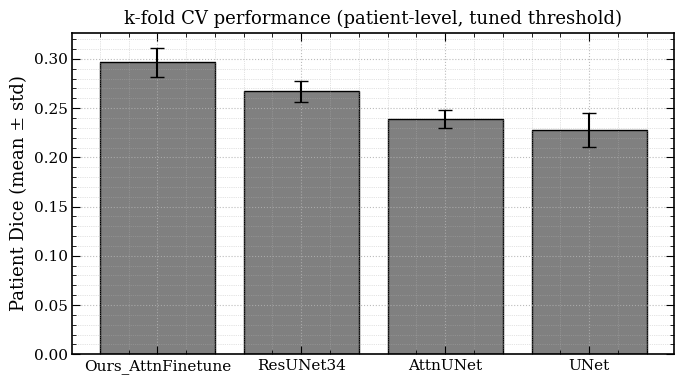

Saved: /kaggle/working/paper_outputs_nb4/bar_patient_dice_tuned_mean_std.png


In [24]:
fig, ax = plt.subplots(figsize=(7.0, 4.0))

x = np.arange(len(agg_df))
means = agg_df["test_patient_dice@tuned_mean"].values
stds  = agg_df["test_patient_dice@tuned_std"].values
labels = agg_df["model"].values

ax.bar(x, means, yerr=stds, capsize=5, color="gray", edgecolor="black")
ax.set_xticks(x, labels)
ax.set_ylabel("Patient Dice (mean ± std)")
ax.set_title("k-fold CV performance (patient-level, tuned threshold)")
paper_axes(ax)

fig.tight_layout()
png = OUT_DIR / "bar_patient_dice_tuned_mean_std.png"
fig.savefig(png, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", png)
